In [1]:
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
import seaborn as sns
from sklearn import metrics
import time
import pickle
import metric_learn
from sklearn.decomposition import PCA  
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import LocalOutlierFactor
import functools
import tempfile
import datetime
import tensorflow as tf
import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from utils import make_data, make_data_rev, make_label, calc_leq, leq_filter, validate, figure, figure_detail, plot_timeseries, fig_pr, auc_gs, fig_th_f

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8595415097614933587
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7798259712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4895895732636146145
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8817180656418269940
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7798259712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15373220622475626804
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
data_dir='filtered_csv_label'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

,original,label,time,day
0,53.4,0,15,0
1,52.8,0,15,0
2,52.8,0,15,0
3,53.2,0,15,0
4,53.6,0,15,0
...,...,...,...,...
3995345,45.9,0,5,9
3995346,45.6,0,5,9
3995347,45.8,0,5,9
3995348,45.7,0,5,9


## ホールドアウト検証
## 訓練、テストへ分割
* テスト（最終評価用）：6, 7, 8, 9 日目
---
ラベル付け
* 全体：0, 1, 2, 3, 4, 5 日目
* 訓練ローテ：(訓練、ラベル付与対象)=([0, 1, 2, 3, 4], 5)・・・([5, 0, 1, 2, 3], 4)

In [3]:
test_day=[6, 7, 8, 9]
semi_train_day=[0, 1, 2, 3, 4, 5]

test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)
semi_train_df=df[(df['day'].isin(semi_train_day))].reset_index(drop=True)

In [4]:
df_list=[]

window=15
for i in set(df['day']):
    lag=[] 
    lag.append(make_data_rev(semi_train_df.loc[semi_train_df['day']==i, ['original']], 'original', window))
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['day']])
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
semi_train_df=pd.concat(df_list)
semi_train_df=semi_train_df.dropna().reset_index(drop=True)
semi_train_df.loc[:, 'lstmaed']=0
semi_train_df.loc[:, 'lstmaed_label']=0

In [5]:
semi_train_df

,original,original_next1,original_next2,original_next3,original_next4,original_next5,original_next6,original_next7,original_next8,original_next9,original_next10,original_next11,original_next12,original_next13,original_next14,day,label,lstmaed,lstmaed_label
0,53.4,52.8,52.8,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,0,0,0,0
1,52.8,52.8,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,0,0,0,0
2,52.8,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,54.9,0,0,0,0
3,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,54.9,55.0,0,0,0,0
4,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,54.9,55.0,55.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2393321,45.2,45.0,44.6,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0,5,0,0,0
2393322,45.0,44.6,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0,45.2,5,0,0,0
2393323,44.6,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0,45.2,45.1,5,0,0,0
2393324,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0,45.2,45.1,45.1,5,0,0,0


## LSTM_autoencoder

In [6]:
units=3
print(f'units:{units}')
LSTM_autoencoder = keras.Sequential()
LSTM_autoencoder.add(keras.layers.LSTM(
    units=units,
    input_shape=(window, 1),
))
# LSTM_autoencoder.add(keras.layers.Dropout(rate=0.5))
LSTM_autoencoder.add(keras.layers.RepeatVector(n=window))
LSTM_autoencoder.add(keras.layers.LSTM(
    units=units, 
    return_sequences=True,
))
# LSTM_autoencoder.add(keras.layers.Dropout(rate=0.5))
LSTM_autoencoder.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=1)
  )
)

units:3


2024/01/05 00:13:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/01/05 00:13:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/01/05 00:13:08 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



訓練データ：[1, 2, 3, 4, 5]
ラベル付与データ：[0]日目
Epoch 1/100
7662/7662 [==============================] - 67s 8ms/step - loss: 0.0120 - val_loss: 0.0073
Epoch 2/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 3/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 4/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 5/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 6/100
7662/7662 [==============================] - 62s 8ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 7/100
7662/7662 [==============================] - 62s 8ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 8/100
7662/7662 [==============================] - 62s 8ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 9/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 10/100
7662/7662 [===

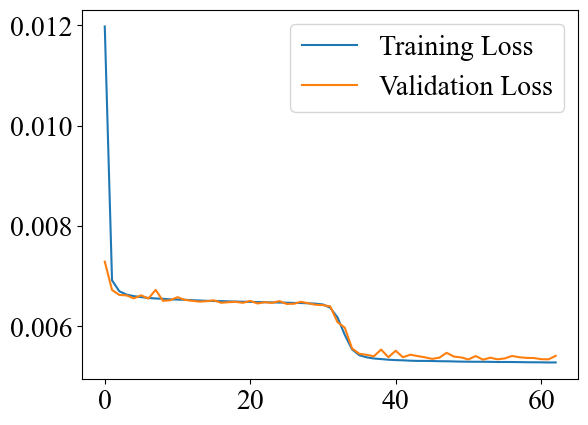

13500/13500 [==============================] - 39s 3ms/step
------------------------------------------------------


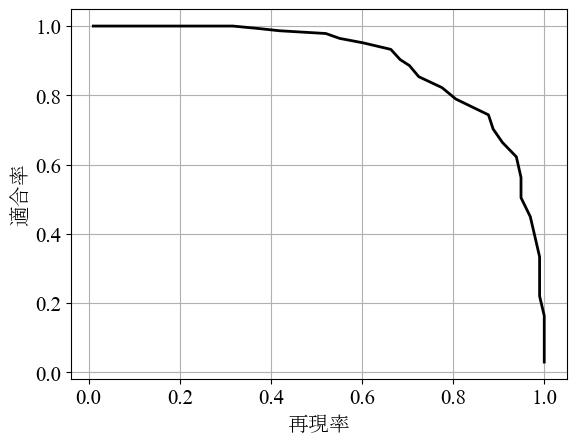

AUC：0.88768842191311
理想の閾値：0.23076923076923075
F値（最高）：0.8050463290358847
適合率（F値が最高の時）：0.7436082102988837
再現率（F値が最高の時）：0.8775510204081632
訓練データ：[0, 2, 3, 4, 5]
ラベル付与データ：[1]日目
Epoch 1/100
8226/8226 [==============================] - 67s 8ms/step - loss: 0.0050 - val_loss: 0.0063
Epoch 2/100
8226/8226 [==============================] - 64s 8ms/step - loss: 0.0050 - val_loss: 0.0061
Epoch 3/100
8226/8226 [==============================] - 63s 8ms/step - loss: 0.0050 - val_loss: 0.0062
Epoch 4/100
8226/8226 [==============================] - 63s 8ms/step - loss: 0.0050 - val_loss: 0.0061
Epoch 5/100
8226/8226 [==============================] - 63s 8ms/step - loss: 0.0050 - val_loss: 0.0062
Epoch 6/100
8226/8226 [==============================] - 63s 8ms/step - loss: 0.0050 - val_loss: 0.0062
Epoch 7/100
8226/8226 [==============================] - 63s 8ms/step - loss: 0.0050 - val_loss: 0.0062
Epoch 8/100
8226/8226 [==============================] - 63s 8ms/step - loss: 0.0050 - val_loss: 0

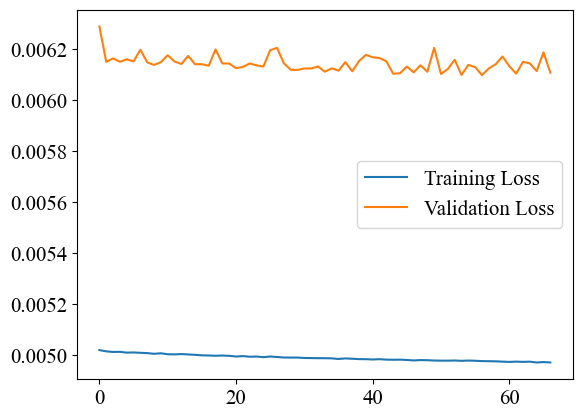

8984/8984 [==============================] - 27s 3ms/step
------------------------------------------------------


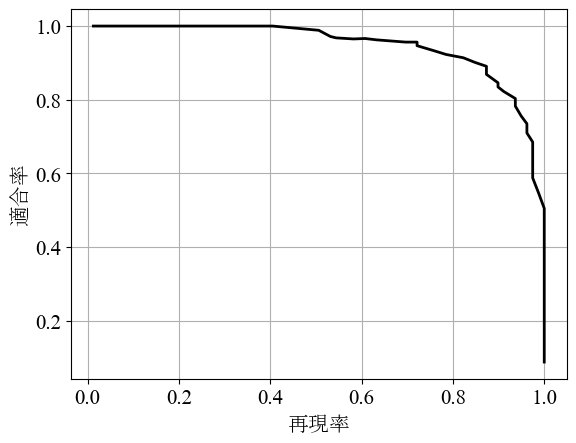

AUC：0.9349974258493728
理想の閾値：0.41538461538461535
F値（最高）：0.8819906749445234
適合率（F値が最高の時）：0.8907335907335907
再現率（F値が最高の時）：0.8734177215189873
訓練データ：[0, 1, 3, 4, 5]
ラベル付与データ：[2]日目
Epoch 1/100
7662/7662 [==============================] - 66s 8ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 2/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 3/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 4/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 5/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 6/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 7/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 8/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0051 - val_loss:

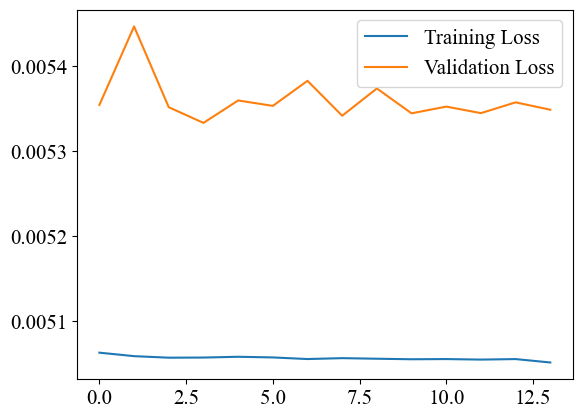

13500/13500 [==============================] - 40s 3ms/step
------------------------------------------------------


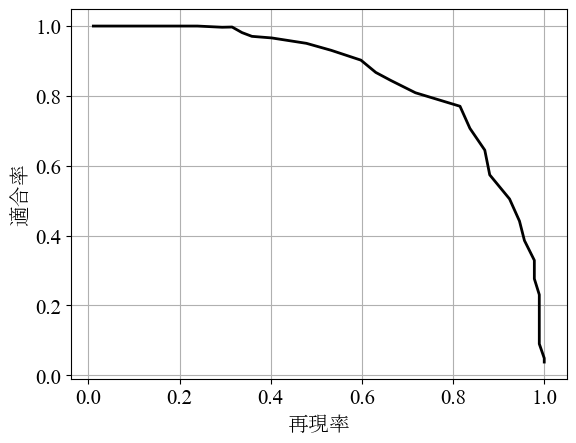

AUC：0.8459961507243127
理想の閾値：0.21538461538461537
F値（最高）：0.7921536047751464
適合率（F値が最高の時）：0.7703589347742185
再現率（F値が最高の時）：0.8152173913043478
訓練データ：[0, 1, 2, 4, 5]
ラベル付与データ：[3]日目
Epoch 1/100
7873/7873 [==============================] - 67s 8ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 2/100
7873/7873 [==============================] - 62s 8ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 3/100
7873/7873 [==============================] - 62s 8ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 4/100
7873/7873 [==============================] - 62s 8ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 5/100
7873/7873 [==============================] - 62s 8ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 6/100
7873/7873 [==============================] - 62s 8ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 7/100
7873/7873 [==============================] - 62s 8ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 8/100
7873/7873 [==============================] - 62s 8ms/step - loss: 0.0052 - val_loss:

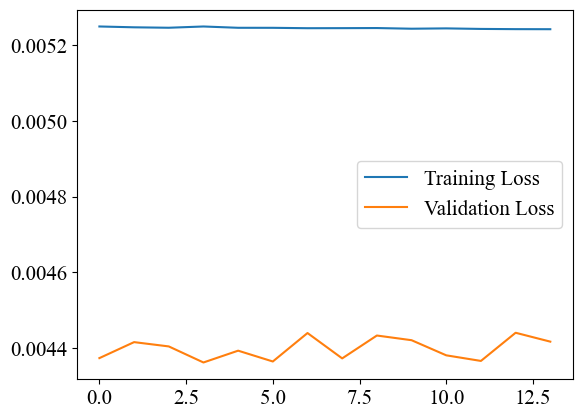

11812/11812 [==============================] - 34s 3ms/step
------------------------------------------------------


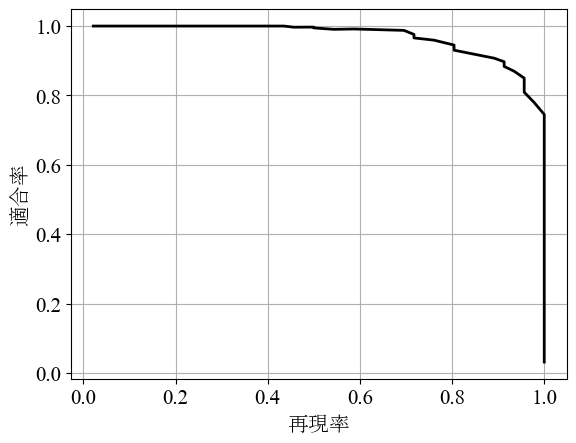

AUC：0.9475856646489795
理想の閾値：0.32307692307692304
F値（最高）：0.904975436051304
適合率（F値が最高の時）：0.8970487302676733
再現率（F値が最高の時）：0.9130434782608695
訓練データ：[0, 1, 2, 3, 5]
ラベル付与データ：[4]日目
Epoch 1/100
7662/7662 [==============================] - 65s 8ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 2/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 3/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 4/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 5/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 6/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0059 - val_loss: 0.0064
Epoch 7/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 8/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0059 - val_loss: 

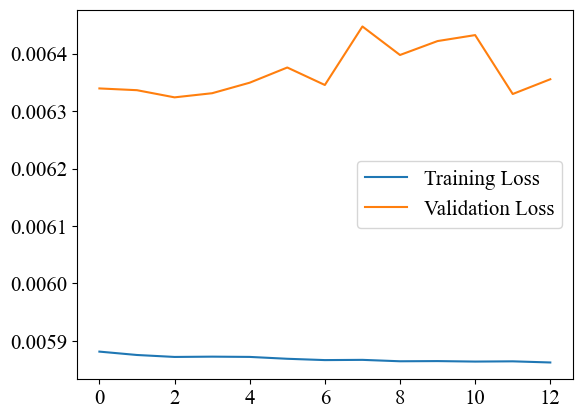

13499/13499 [==============================] - 40s 3ms/step
------------------------------------------------------


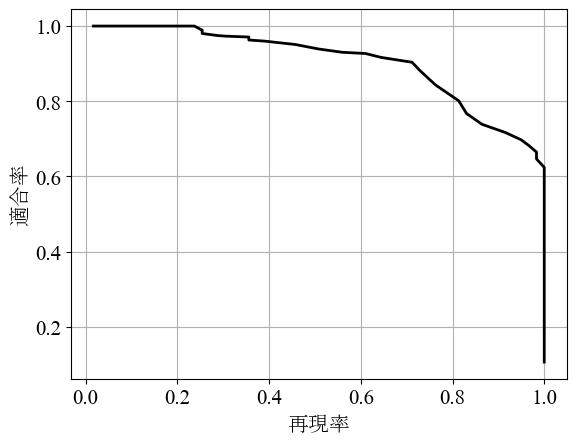

AUC：0.8892455860532517
理想の閾値：0.2769230769230769
F値（最高）：0.8073566143109722
適合率（F値が最高の時）：0.8012477718360071
再現率（F値が最高の時）：0.8135593220338984
訓練データ：[0, 1, 2, 3, 4]
ラベル付与データ：[5]日目
Epoch 1/100
7662/7662 [==============================] - 65s 8ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 2/100
7662/7662 [==============================] - 60s 8ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 3/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 4/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 5/100
7662/7662 [==============================] - 61s 8ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 6/100
7662/7662 [==============================] - 60s 8ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 7/100
7662/7662 [==============================] - 60s 8ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 8/100
7662/7662 [==============================] - 60s 8ms/step - loss: 0.0053 - val_loss: 

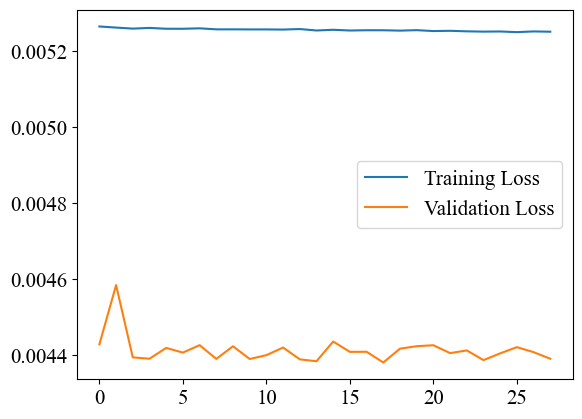

13500/13500 [==============================] - 39s 3ms/step
------------------------------------------------------


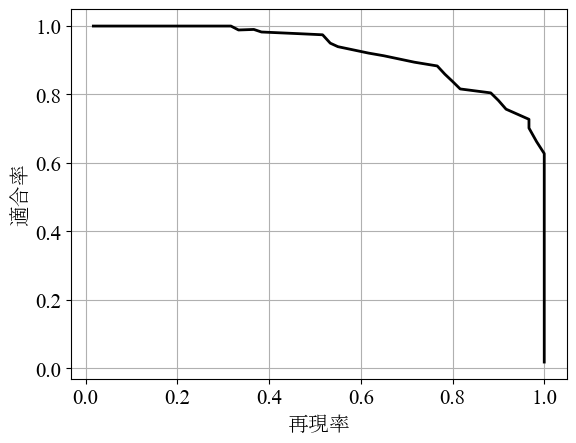

AUC：0.9073120035379225
理想の閾値：0.3692307692307692
F値（最高）：0.8421718864018825
適合率（F値が最高の時）：0.8046757164404224
再現率（F値が最高の時）：0.8833333333333333
=============CV_AUC_mean===============
0.902137542121158


In [7]:
mlflow.autolog(log_models=False)

# 実験をアクティブ化(設定)する。ない場合は新たな実験を作成してアクティブ化する
mlflow.set_experiment("CV")
run_name='result'
with mlflow.start_run(run_name=run_name):
    test_day=[6, 7, 8, 9]
    semi_train_day=[0, 1, 2, 3, 4, 5]
    mlflow.log_params({'CV_day':semi_train_day})
    auc_list=[]
    for day in semi_train_day:
        
        # テストデータとする日
        i=[day]
        label_train_day=[k for k in semi_train_day if k not in i]
        label_grant_day=i
        print(f'訓練データ：{label_train_day}')
        print(f'ラベル付与データ：{label_grant_day}日目')

        semi_train_x=semi_train_df[(semi_train_df['day'].isin(label_train_day))][semi_train_df.columns[:-4]].reset_index(drop=True)
        labeling_x=semi_train_df[(semi_train_df['day'].isin(label_grant_day))][semi_train_df.columns[:-4]].reset_index(drop=True)
        # tf.reduce_min関数を使用して、train_dataテンソル内の最小値を計算しています。
        # min_valにはtrain_data内の最小値が代入されます。
        min_val = tf.reduce_min(semi_train_x)
        # tf.reduce_max関数を使用して、train_dataテンソル内の最大値を計算しています。
        # max_valにはtrain_data内の最大値が代入されます。
        max_val = tf.reduce_max(semi_train_x)
        train_data = (semi_train_x.values - min_val) / (max_val - min_val)
        labeling_data = (labeling_x.values - min_val) / (max_val - min_val)

        # データをモデルに入力する形状に整形し,データの型をtf.float32に変換
        train_data = tf.cast(train_data[:, :, np.newaxis], tf.float32)
        labeling_data = tf.cast(labeling_data[:, :, np.newaxis], tf.float32)

        LSTM_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                                 loss='mae')

        callback = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=10,
            restore_best_weights=True
        )
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        history = LSTM_autoencoder.fit(train_data, train_data, 
              epochs=100, 
              batch_size=256,
              validation_data=(labeling_data, labeling_data),
              callbacks=[callback],
              shuffle=True)

        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.show()

        reconstructions = LSTM_autoencoder.predict(labeling_data)
        #     異常度算出
        d= tf.keras.losses.mae(reconstructions[:, :, 0], labeling_data[:, :, 0]).numpy()
        semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'lstmaed']=d
        print('------------------------------------------------------')

        test_v=semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), ['original', 'label']].copy().reset_index(drop=True)
        d_test=(d-d.min())/(d.max()-d.min())

        thr_bins=50
        p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
        f_max=f_score.max()
        p_max=p_score[np.argmax(f_score)]
        r_max=r_score[np.argmax(f_score)]
        print('\033[31m'+f'AUC：{auc}'+'\033[0m')
        print(f'理想の閾値：{thr}')
        print(f'F値（最高）：{f_max}')
        print(f'適合率（F値が最高の時）：{p_max}')
        print(f'再現率（F値が最高の時）：{r_max}')

        # Log the loss metric
        mlflow.log_metric("test_AUC", auc)
        mlflow.log_metric("test_Fscore_best", f_max)
        mlflow.log_metric("test_Precision_when Fscore Best", p_max)
        mlflow.log_metric("test_Recall_when Fscore Best", r_max)
        auc_list.append(auc)

    #平均
    auc_mean=np.mean(auc_list)
    # Log the loss metric
    mlflow.log_metric("CV_test_AUC", auc_mean)
    print('=============CV_AUC_mean===============')
    print(auc_mean)

## 訓練データとテストデータの重複を確認

In [14]:
semi_train_x.drop_duplicates()

,original,original_next1,original_next2,original_next3,original_next4,original_next5,original_next6,original_next7,original_next8,original_next9,original_next10,original_next11,original_next12,original_next13,original_next14
0,53.4,52.8,52.8,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9
1,52.8,52.8,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9
2,52.8,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,54.9
3,53.2,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,54.9,55.0
4,53.6,54.0,54.7,55.7,55.5,55.7,55.6,55.8,55.7,55.0,54.9,54.9,54.9,55.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961350,45.0,45.4,45.5,45.5,45.2,45.3,45.9,45.6,46.2,46.1,45.8,45.8,45.0,45.2,45.1
1961351,45.4,45.5,45.5,45.2,45.3,45.9,45.6,46.2,46.1,45.8,45.8,45.0,45.2,45.1,45.1
1961352,45.5,45.5,45.2,45.3,45.9,45.6,46.2,46.1,45.8,45.8,45.0,45.2,45.1,45.1,45.2
1961353,45.5,45.2,45.3,45.9,45.6,46.2,46.1,45.8,45.8,45.0,45.2,45.1,45.1,45.2,45.3


In [15]:
labeling_x.drop_duplicates()

,original,original_next1,original_next2,original_next3,original_next4,original_next5,original_next6,original_next7,original_next8,original_next9,original_next10,original_next11,original_next12,original_next13,original_next14
0,46.9,47.2,47.4,47.8,47.9,47.8,48.4,49.0,49.7,50.5,52.0,53.0,54.5,54.7,55.5
1,47.2,47.4,47.8,47.9,47.8,48.4,49.0,49.7,50.5,52.0,53.0,54.5,54.7,55.5,55.0
2,47.4,47.8,47.9,47.8,48.4,49.0,49.7,50.5,52.0,53.0,54.5,54.7,55.5,55.0,55.7
3,47.8,47.9,47.8,48.4,49.0,49.7,50.5,52.0,53.0,54.5,54.7,55.5,55.0,55.7,55.7
4,47.9,47.8,48.4,49.0,49.7,50.5,52.0,53.0,54.5,54.7,55.5,55.0,55.7,55.7,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431966,45.2,45.0,44.6,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0
431967,45.0,44.6,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0,45.2
431968,44.6,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0,45.2,45.1
431969,45.2,44.9,44.9,45.1,45.7,45.0,45.6,45.4,44.8,45.1,45.4,45.0,45.2,45.1,45.1


In [16]:
duplicates = pd.merge(semi_train_x.drop_duplicates(), labeling_x.drop_duplicates(), how='inner')
duplicates

,original,original_next1,original_next2,original_next3,original_next4,original_next5,original_next6,original_next7,original_next8,original_next9,original_next10,original_next11,original_next12,original_next13,original_next14


In [8]:
! mlflow gc --backend-store-uri ./mlruns

In [ ]:
! mlflow ui --port 5004 

In [10]:
auc_list

[0.88768842191311,
 0.9349974258493728,
 0.8459961507243127,
 0.9475856646489795,
 0.8892455860532517,
 0.9073120035379225]